In [1]:
import pdb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lib.main import person, economy
from utils.viz_econ import *

In [2]:
prices = {
    'food': 5,
    'cloth': 5
}

# Run

## No trading

If no trading, then total wealth will be lower.

In [3]:
econ_1 = economy(run_days=100, prices=prices)
econ_2 = economy(run_days=100, prices=prices, policy='No trading')

In [4]:
econ_1.run_economy(log_file='log_1')

Log saved to log_1.txt!


In [5]:
econ_2.run_economy(log_file='log_2')

Log saved to log_2.txt!


In [6]:
econs={'Base': econ_1, 'No trading': econ_2}

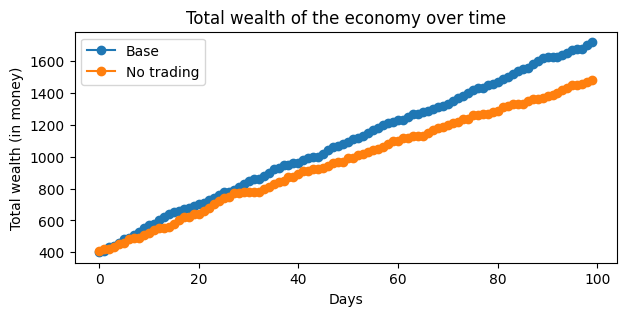

In [7]:
fig = plot_compare_econ(econs)
fig

Log saved to log_file.txt!


Log saved to log_file.txt!
